In [1]:
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py as hp5

In [2]:
from matplotlib import colors
from matplotlib import cm
from sctriangulate.colors import build_custom_continuous_cmap

In [3]:
# Pylinas core modules
import Pk_library as PKL
import MAS_library as MASL

# Reading Data for *StrongFB* and doing analysis

In [4]:
# reading data hdf5 snapshots
basePath = "StrongFBL0025N0376_snapshot_028_z000p000/snap_028_z000p000."

data = np.array([[0,0,0]], dtype=np.float32)

for i in tqdm(range(16), desc="Reading data"):
    fileName = basePath + str(i) + ".hdf5"
    f = hp5.File(fileName, 'r')
    temp = np.array(f['PartType1/Coordinates'][:], dtype=np.float32)
    data = np.append(data, temp, axis=0)
    del f,temp
data = data[1:]

Reading data: 100%|██████████| 16/16 [00:27<00:00,  1.69s/it]


## Plotting the data

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


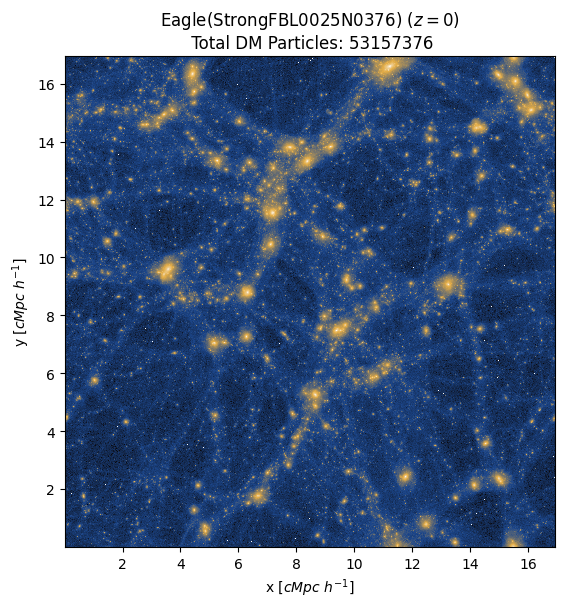

In [5]:
# creating colormap for plotting
new_cmap = build_custom_continuous_cmap([9,9,14], [28, 70, 138], [227, 172, 70], [255,255,255])

# plotting
plt.figure(figsize=(7,6.5), dpi=100)
ax = plt.gca()
ax.set_aspect('equal')
plt.hist2d(data[:,0], data[:,1], norm =colors.LogNorm(), cmap=new_cmap, bins=1024);
# plt.colorbar()

plt.title('Eagle(StrongFBL0025N0376) ($z=0$)\n Total DM Particles: '+str(len(data)))

plt.xlabel('x [$cMpc ~h^{-1}$]')
plt.ylabel('y [$cMpc ~h^{-1}$]')


plt.savefig('FinalProducts/Eagle-StrongFBL0025N0376_DM.jpg', dpi=300, bbox_inches='tight')

## Computing 2pCF and Power Spectrum using Pylinas

In [6]:
## computing xi(r)
grid = 350
h = 0.677
BoxSize = 25*h
verbose = True
Np = len(data)
MAS = 'CIC'

print("Getting position and delta array")
pos = np.array(data, dtype=np.float32)
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
print("Constructing 3D density field")
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)
delta /= np.mean(delta, dtype=np.float64);
delta -= 1.0

# compute the correlation function
print("Computing correlation function")
axis = 0
threads=12
CF     = PKL.Xi(delta, BoxSize, MAS, axis, threads)


# get the attributes
print("Getting attributes")
r      = CF.r3D      #radii in Mpc/h
xi0    = CF.xi[:,0]  #correlation function (monopole)
xi2    = CF.xi[:,1]  #correlation function (quadrupole)
xi4    = CF.xi[:,2]  #correlation function (hexadecapole)
Nmodes = CF.Nmodes3D #number of modes

print("\n\nDone!!")

Getting position and delta array
Constructing 3D density field

Using CIC mass assignment scheme
Time taken = 1.443 seconds

Computing correlation function

Computing correlation function of the field...
Time to complete loop = 0.27
Time taken = 1.50 seconds
Getting attributes


Done!!


In [7]:
## computing P(k)
Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole


Computing power spectrum of the field...
Time to complete loop = 1.74
Time taken = 1.94 seconds


In [8]:
#getting only non-nan values for log(xi0) and log(Pk0)
xi0_filtered = xi0[~np.isnan(np.log10(xi0))]
r_filterd = r[~np.isnan(np.log10(xi0))]

Pk0_filtered = Pk0[~np.isnan(np.log10(Pk0))]
k_filterd = k[~np.isnan(np.log10(Pk0))]

/tmp/ipykernel_6831/2713456153.py:2: RuntimeWarning: invalid value encountered in log10
  xi0_filtered = xi0[~np.isnan(np.log10(xi0))]
/tmp/ipykernel_6831/2713456153.py:3: RuntimeWarning: invalid value encountered in log10
  r_filterd = r[~np.isnan(np.log10(xi0))]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Plotting


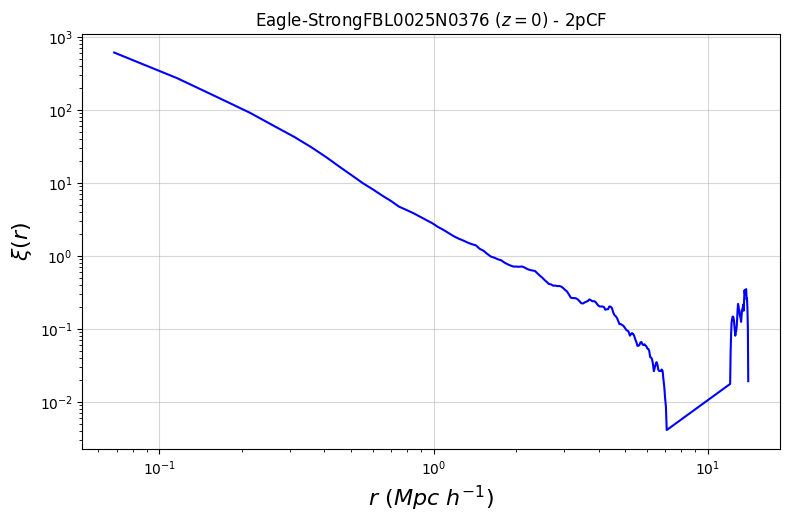

In [9]:
# log-log plot
print("Plotting")
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(r_filterd,xi0_filtered, color='blue')
#setting log scale
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)

plt.title('Eagle-StrongFBL0025N0376 ($z=0$) - 2pCF')
plt.xlabel('$r ~(Mpc~h^{-1})$',  fontsize=16)
plt.ylabel("$\\xi(r)$", fontsize=16)

plt.savefig('FinalProducts/2pCF_Eagle-StrongFBL0025N0376.jpg', dpi=300, bbox_inches='tight')
# plt.show()

Plotting


Text(0, 0.5, '$P(k)$')

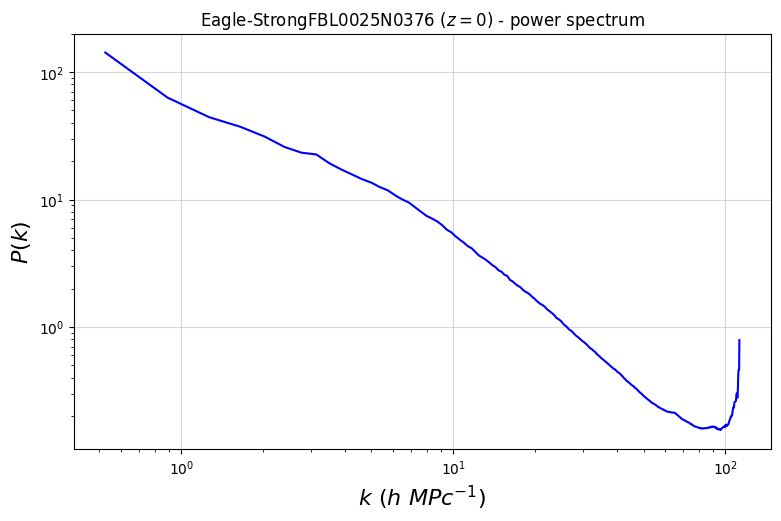

In [10]:
# log-log plot
print("Plotting")
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(k_filterd,Pk0_filtered, color='blue')
#setting log scale
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)

plt.title('Eagle-StrongFBL0025N0376 ($z=0$) - power spectrum')
plt.xlabel('$k ~(h~MPc^{-1})$',  fontsize=16)
plt.ylabel("$P(k)$", fontsize=16)


In [11]:
# saving r_filterd and xi0_filtered in a HDF5 file in a Group
print("Saving data 2pCF")
h5f = hp5.File('2pCF_Eagle.hdf5', 'a')
# creating a group
grp = h5f.create_group("StrongFB/DM")
# creating a dataset
dset = grp.create_dataset("xi0", data=xi0_filtered)
dset = grp.create_dataset("r", data=r_filterd)  
# h5f.close()
print("Done!!")

print("Saving data P(k)")
h5f1 = hp5.File('Pk_Eagle.hdf5', 'a')
# creating a group
grp = h5f1.create_group("StrongFB/DM")
# creating a dataset
dset = grp.create_dataset("Pk0", data=Pk0_filtered)
dset = grp.create_dataset("k", data=k_filterd)  
# h5f.close()
print("Done!!")

Saving data 2pCF
Done!!
Saving data P(k)
Done!!


## Computing 2pCF using Corrfunc

Don't run the below cell...it is resulting in unresponsive processes even though there is sufficient memory avaliable.

In [34]:
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf

In [ ]:
X = data[:,0] 
Y = data[:,1]
Z = data[:,2]

N = len(data)
boxsize = 50
rand_X = np.random.uniform(0, boxsize, N)
rand_Y = np.random.uniform(0, boxsize, N)
rand_Z = np.random.uniform(0, boxsize, N)
nthreads = 10

nbins = 32
bins = np.linspace(0.0, 10, nbins+1)
# Auto pair counts in DD
autocorr=1
DD_counts = DD(autocorr, nthreads, bins, X, Y, Z,
               periodic=False, verbose=True, boxsize=boxsize)

autocorr=0
DR_counts = DD(autocorr, nthreads, bins, X, Y, Z,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z,
               periodic=False, verbose=True, boxsize=boxsize)

# Auto pairs counts in RR
autocorr=1
RR_counts = DD(autocorr, nthreads, bins, rand_X, rand_Y, rand_Z,
                periodic=False, verbose=True, boxsize=boxsize)


In [28]:
#clear the memory
# del X,Y,Z,rand_X,rand_Y,rand_Z
del data

# Reading data from *WeakFB* and doing analysis

In [13]:
# reading data hdf5 snapshots
basePath = "WeakFBL0025N0376_snapshot_028_z000p000/snap_028_z000p000."

data = np.array([[0,0,0]], dtype=np.float32)

for i in tqdm(range(16), desc="Reading data"):
    fileName = basePath + str(i) + ".hdf5"
    f = hp5.File(fileName, 'r')
    temp = np.array(f['PartType1/Coordinates'][:], dtype=np.float32)
    data = np.append(data, temp, axis=0)
    f.close()
data = data[1:]

Reading data: 100%|██████████| 16/16 [00:33<00:00,  2.11s/it]


## Plotting DM distribution

Creating colormap
Plotting


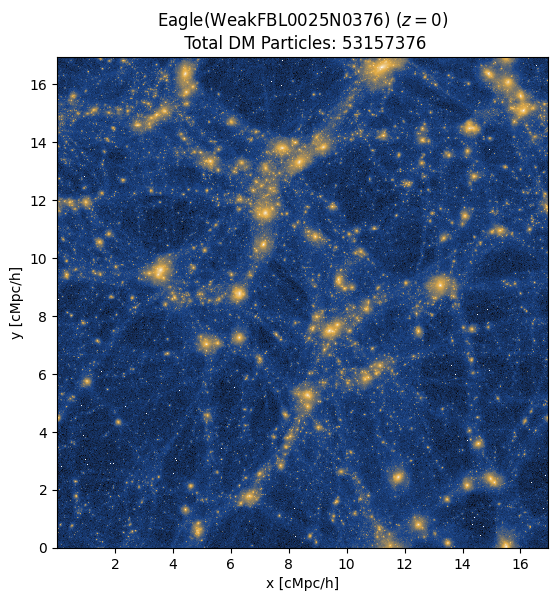

In [14]:
##Plotting matter distribution
# creating colormap for plotting
print("Creating colormap")
new_cmap = build_custom_continuous_cmap([9,9,14], [28, 70, 138], [227, 172, 70], [255,255,255])

# plotting
print("Plotting")
plt.figure(figsize=(6.5,6.5), dpi=100)
ax = plt.gca()
ax.set_aspect('equal')
plt.hist2d(data[:,0], data[:,1], norm =colors.LogNorm(), cmap=new_cmap, bins=1024);

plt.title('Eagle(WeakFBL0025N0376) ($z=0$)\n Total DM Particles: '+str(len(data)))

plt.xlabel('x [cMpc/h]')
plt.ylabel('y [cMpc/h]')

plt.savefig('FinalProducts/Eagle-WeakFBL0025N0376_DM.jpg', dpi=300, bbox_inches='tight')
# plt.show()

## Computing 2pCF

In [15]:
## computing xi(r)
grid = 350
BoxSize = 25*h
verbose = True
Np = len(data)
MAS = 'CIC'

print("Getting position and delta array")
pos = np.array(data, dtype=np.float32)
delta = np.zeros((grid,grid,grid), dtype=np.float32)

# construct 3D density field
print("Constructing 3D density field")
MASL.MA(pos, delta, BoxSize, MAS, verbose=verbose)
delta /= np.mean(delta, dtype=np.float64);
delta -= 1.0

# compute the correlation function
print("Computing correlation function")
axis = 0
threads=12
CF     = PKL.Xi(delta, BoxSize, MAS, axis, threads)


# get the attributes
print("Getting attributes")
r      = CF.r3D      #radii in Mpc/h
xi0    = CF.xi[:,0]  #correlation function (monopole)
xi2    = CF.xi[:,1]  #correlation function (quadrupole)
xi4    = CF.xi[:,2]  #correlation function (hexadecapole)
Nmodes = CF.Nmodes3D #number of modes

print("\n\nDone!!")

Getting position and delta array
Constructing 3D density field

Using CIC mass assignment scheme
Time taken = 1.470 seconds

Computing correlation function

Computing correlation function of the field...
Time to complete loop = 0.26
Time taken = 1.45 seconds
Getting attributes


Done!!


In [16]:
## computing P(k)
Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

# 3D P(k)
k       = Pk.k3D
Pk0     = Pk.Pk[:,0] #monopole


Computing power spectrum of the field...
Time to complete loop = 1.66
Time taken = 1.87 seconds


In [17]:
#getting only non-nan values for log(xi0) and log(Pk0)
xi0_filtered = xi0[~np.isnan(np.log10(xi0))]
r_filterd = r[~np.isnan(np.log10(xi0))]
Pk0_filtered = Pk0[~np.isnan(np.log10(xi0))]
k_filterd = k[~np.isnan(np.log10(xi0))]

/tmp/ipykernel_6831/3470078429.py:2: RuntimeWarning: invalid value encountered in log10
  xi0_filtered = xi0[~np.isnan(np.log10(xi0))]
/tmp/ipykernel_6831/3470078429.py:3: RuntimeWarning: invalid value encountered in log10
  r_filterd = r[~np.isnan(np.log10(xi0))]
/tmp/ipykernel_6831/3470078429.py:4: RuntimeWarning: invalid value encountered in log10
  Pk0_filtered = Pk0[~np.isnan(np.log10(xi0))]
/tmp/ipykernel_6831/3470078429.py:5: RuntimeWarning: invalid value encountered in log10
  k_filterd = k[~np.isnan(np.log10(xi0))]


Plotting


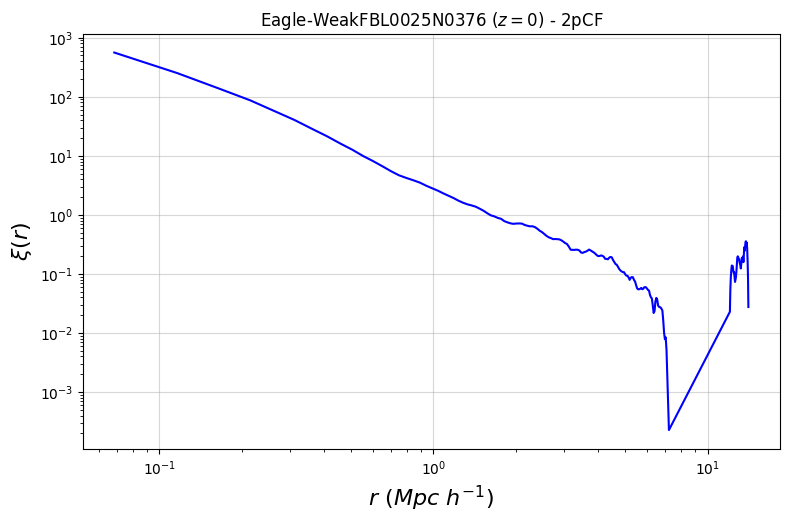

In [18]:
# log-log plot of 2pCF
print("Plotting")
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(r_filterd,xi0_filtered, color='blue')
#setting log scale
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)

plt.title('Eagle-WeakFBL0025N0376 ($z=0$) - 2pCF')
plt.xlabel('$r ~(Mpc~h^{-1})$',  fontsize=16)
plt.ylabel("$\\xi(r)$", fontsize=16)

plt.savefig('FinalProducts/2pCF_Eagle-WeakFBL0025N0376.jpg', dpi=300, bbox_inches='tight')
# plt.show()

Plotting


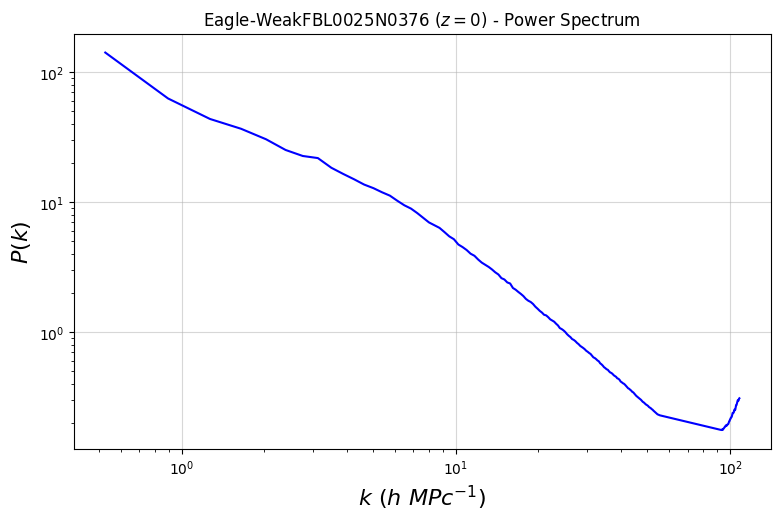

In [19]:
# log-log plot of P(k)
print("Plotting")
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(k_filterd,Pk0_filtered, color='blue')
#setting log scale
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)

plt.title('Eagle-WeakFBL0025N0376 ($z=0$) - Power Spectrum');
plt.xlabel('$k ~(h~MPc^{-1})$',  fontsize=16);
plt.ylabel("$P(k)$", fontsize=16);

# plt.show()

In [20]:
# saving r_filterd and xi0_filtered in a HDF5 file in a Group
print("Saving data 2pCF")
# h5f = hp5.File('FinalProducts/2pCF_Eagle.hdf5', 'a') #not needed since file aready exists
# creating a group
grp1 = h5f.create_group("WeakFB/DM")
# creating a dataset
dset = grp1.create_dataset("xi0", data=xi0_filtered)
dset = grp1.create_dataset("r", data=r_filterd)  
h5f.keys()
h5f.close()

print("Saving data P(k)")
# h5f1 = hp5.File('Pk_Eagle.hdf5', 'a')
# creating a group
grp = h5f1.create_group("WeakFB/DM")
# creating a dataset
dset = grp.create_dataset("Pk0", data=Pk0_filtered)
dset = grp.create_dataset("k", data=k_filterd)  
h5f1.close()

print("Done!!")

Saving data 2pCF
Saving data P(k)
Done!!


# Plotting the correlation function for StrongFB anf WeakFB together

In [22]:
#reading data from the HDF5 file
h5f = hp5.File('FinalProducts/2pCF_Eagle.hdf5', 'r')
h5f1 = hp5.File('FinalProducts/Pk_Eagle.hdf5', 'r')
grp1 = h5f['WeakFB/DM']
grp2 = h5f['StrongFB/DM']
grp3 = h5f1['WeakFB/DM']
grp4 = h5f1['StrongFB/DM']

#getting 2pCF data for WeakFB
xi0_filtered_W = grp1['xi0'][:]
r_filterd_W = grp1['r'][:]

#getting 2pCF data for StrongFB
xi0_filtered_S = grp2['xi0'][:]
r_filterd_S = grp2['r'][:]

#getting P(k) data for WeakFB
Pk0_filtered_W = grp3['Pk0'][:]
k_filterd_W = grp3['k'][:]

#getting P(k) data for StrongFB
Pk0_filtered_S = grp4['Pk0'][:]
k_filterd_S = grp4['k'][:]

h5f.close()
h5f1.close()

Text(0.5, 1.0, '2pCF of WeakFB and StrongFB')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


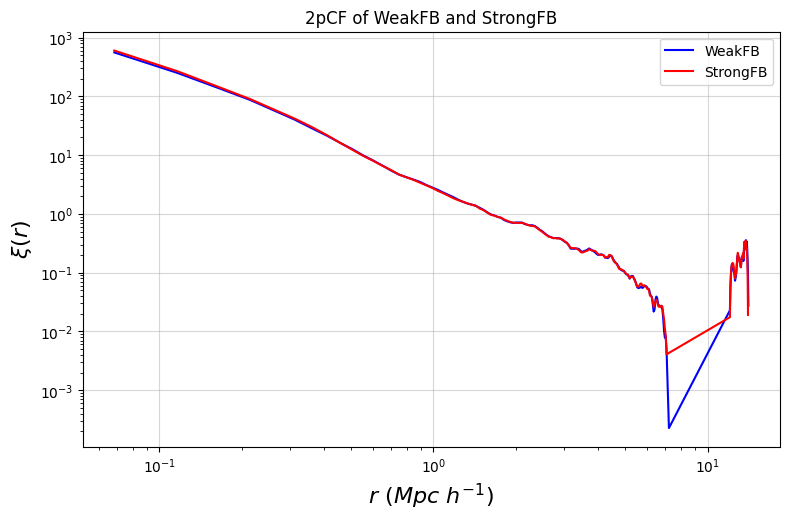

In [23]:
#plotting
# changing font style to Serif
plt.rc('font',**{'family':'serif','serif':['Times']})

plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(r_filterd_W,xi0_filtered_W, color='blue', label='WeakFB')
plt.plot(r_filterd_S,xi0_filtered_S, color='red', label='StrongFB')
#setting log scale
plt.xscale('log')
plt.yscale('log')

plt.legend()

# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)
plt.xlabel('$r ~(Mpc~h^{-1})$',  fontsize=16)
plt.ylabel("$\\xi(r)$", fontsize=16)
plt.title('2pCF of WeakFB and StrongFB')

# plt.savefig('FinalProducts/2pCF_WeakFB_StrongFB.jpg', dpi=300, bbox_inches='tight')

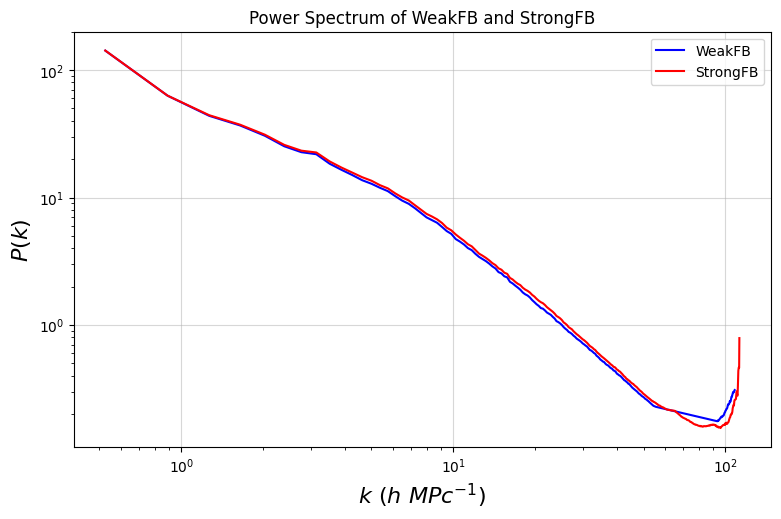

In [24]:
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(k_filterd_W,Pk0_filtered_W, color='blue', label='WeakFB')
plt.plot(k_filterd_S,Pk0_filtered_S, color='red', label='StrongFB')
#setting log scale
plt.xscale('log')
plt.yscale('log')

plt.legend()

# plt.xlim(0.1, 10)
plt.grid(alpha=0.5)
plt.xlabel('$k ~(h~MPc^{-1})$',  fontsize=16)
plt.ylabel("$P(k)$", fontsize=16)
plt.title('Power Spectrum of WeakFB and StrongFB')
plt.savefig('FinalProducts/Pk_WeakFB_StrongFB.jpg', dpi=300, bbox_inches='tight')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


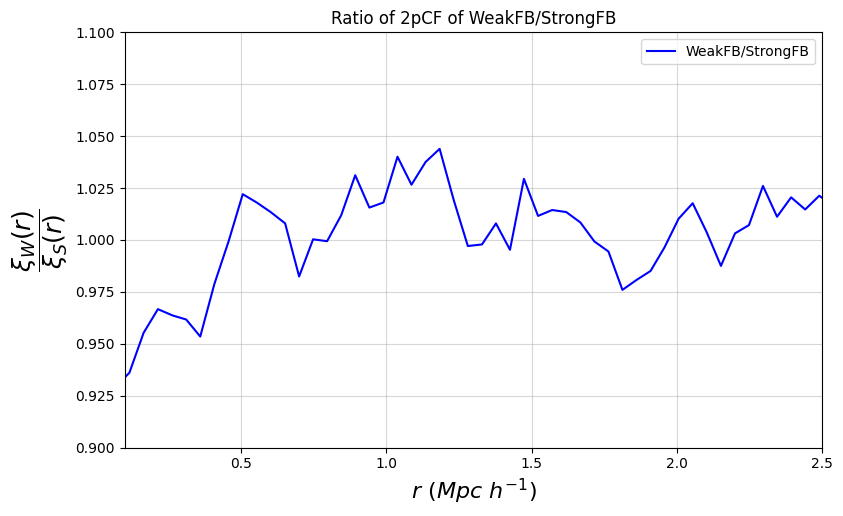

In [25]:
# plotting the ratio of WeakFB/StrongFB
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(r_filterd_S,xi0_filtered_W[:188]/xi0_filtered_S, color='blue', label='WeakFB/StrongFB')
#setting log scale
# plt.xscale('log')
# plt.yscale('log')

plt.xlim(0.1, 2.5)
plt.ylim(0.9,1.1)

plt.legend()

plt.grid(alpha=0.5)
plt.xlabel('$r ~(Mpc~h^{-1})$',  fontsize=16)
plt.ylabel("$\\dfrac{\\xi_{W}(r)}{\\xi_{S}(r)}$", fontsize=18)
plt.title('Ratio of 2pCF of WeakFB/StrongFB')

plt.savefig('FinalProducts/Ratio_2pCF_WeakFB_StrongFB.jpg', dpi=300, bbox_inches='tight')

In [ ]:
# plotting the ratio of WeakFB/StrongFB
plt.figure(figsize=(9,5.5), dpi=100)
plt.plot(k_filterd_S, Pk0_filtered_W/Pk0_filtered_S, color='blue', label='WeakFB/StrongFB')
#setting log scale
# plt.xscale('log')
# plt.yscale('log')

plt.xlim(0.1, 2.5)
plt.ylim(0.9,1.1)

plt.legend()

plt.grid(alpha=0.5)
plt.xlabel('$r ~(Mpc~h^{-1})$',  fontsize=16)
plt.ylabel("$\\dfrac{P_W(k)}{P_S(k)}$", fontsize=18)
plt.title('Ratio of 2pCF of WeakFB/StrongFB')

plt.savefig('FinalProducts/Ratio_Pk_WeakFB_StrongFB.jpg', dpi=300, bbox_inches='tight')